In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from utility import *
from hmmlearn import hmm
import seaborn as sns
import pickle
import matplotlib.cm as cm
import networkx as nx
%matplotlib inline

pd.set_option('display.float_format',lambda x: '%.3f' % x)

folder='/Users/yyu/Documents/Psychology/insight/Drexel/'


In [3]:
includeFreq='all'

flist=frange


featureList=[str((channel,c)) for c in flist for channel in channellist]

In [4]:
for modelname in ['7_all_init_50_iter_50.pkl','7_all_init_5_iter_50.pkl']:
    #with initialization
    with open(folder+'fit_all/'+modelname, "rb") as file: 
        #model=pickle.load(file,encoding='bytes')
        model=pickle.load(file)
    print(model.monitor_)

ConvergenceMonitor(
    history=[-271488452.4164375, -271485619.1791761],
    iter=50,
    n_iter=50,
    tol=0.01,
    verbose=False,
)
ConvergenceMonitor(
    history=[-271483667.5336812, -271482681.3627151],
    iter=50,
    n_iter=50,
    tol=0.01,
    verbose=False,
)


In [5]:
n=len(model.means_)

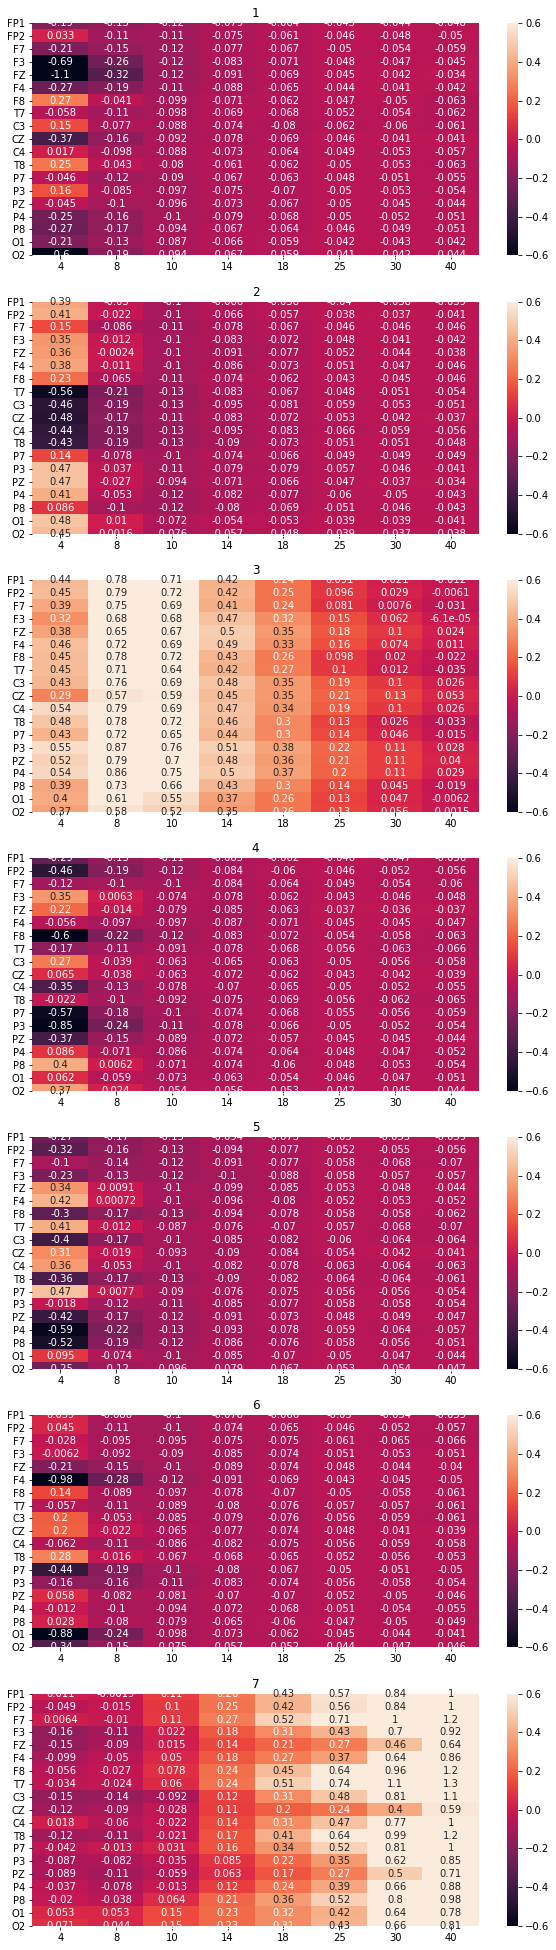

In [5]:

fig,ax=plt.subplots(n,1,figsize=(10,35))

for state in range(n):
    meanSer=pd.Series(model.means_[state],index=featureList)
    meanPD=pd.DataFrame([[meanSer.loc[str((channel,c))] for c in flist] for channel in channellist],
                   index=channellist,columns=flist)
    sns.heatmap(meanPD, annot=True,vmin=-0.6,vmax=0.6,ax=ax[state]).set_title(state+1)


In [6]:
statelabels=['Theta1','Theta2','Alpha','Theta3','Theta4','Theta5','Gamma']

In [7]:
states=[1,2,3,4,5,6,7]
allstate=pd.DataFrame()
for thisfolder in ['nFeature/']:
    for f in os.listdir(folder+thisfolder):
        if f.split('.')[1]!='csv':continue
        subid=f.split('_')[0]
        style=f.split('.')[0].split('_')[1]
        #tmp = pd.read_csv(folder+thisfolder + f, index_col=None)
        tmp=pd.read_csv(folder+thisfolder+f,index_col=None,header=[0,1])
        tmp.columns=[("(\'"+col[0]+"\', "+str(col[1])+")" if len(col[1])<3 else col[0]) for col in tmp.columns.values]
        lenlist = tmp['n'].value_counts()
        state_prob=model.predict_proba(tmp[featureList],lengths=lenlist[tmp['n'].unique()].values)
        stateDf=pd.concat([pd.DataFrame(state_prob,columns=states),tmp[featureList]],axis=1)
        stateDf['style']=style
        stateDf['subid']=subid
        stateDf['n']=tmp['n']
        stateDf['state']=model.predict(tmp[featureList],lengths=lenlist[tmp['n'].unique()].values)
        maxlen=pd.DataFrame({'max':tmp.groupby('n').max()['toOnset'],'l':tmp['n'].value_counts()}).sort_index()
        stateDf['to_Last']=stateDf.apply(lambda r: maxlen.loc[r['n'],'max'],axis=1)#set to largetst toOnSet
        stateDf['to_Last']=tmp['toOnset']-stateDf['to_Last']
        stateDf['to_Onset']=np.round(1000*tmp['toOnset']).astype(int)
        stateDf['to_Last']=np.round(1000*stateDf['to_Last']).astype(int)+500
        allstate=pd.concat([allstate,stateDf])
allstate['id']=allstate.apply(lambda r: (r['subid'],r['n']), axis=1)

In [9]:
allstate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003215 entries, 0 to 23993
Columns: 166 entries, 1 to id
dtypes: float64(159), int64(4), object(3)
memory usage: 1.2+ GB


In [223]:
allstate[states].mean()

1   0.037
2   0.174
3   0.165
4   0.158
5   0.138
6   0.152
7   0.176
dtype: float64

In [547]:
len(allstate['subid'].unique())

39

# Path Plot

In [8]:
allstateDF={'ANA':allstate[allstate['style']=='ANA'],
            'INS':allstate[allstate['style']=='INS'],
            'TO':allstate[allstate['style']=='TO']}

In [9]:
style='TO'
thisID=allstateDF[style]['id'].unique()
tmp=allstateDF[style][allstateDF[style]['id']==thisID[1]].set_index('to_Onset')
tmp.index=(tmp.index.values)/1000
tmp=tmp[states].T


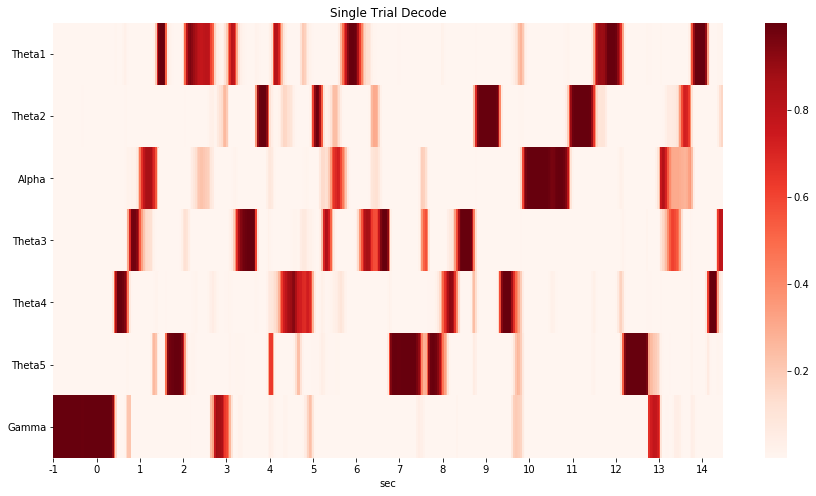

In [10]:
fig,ax=plt.subplots(1,figsize=(15,8))
sns.heatmap(tmp.loc[states],ax=ax,cmap="Reds")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 25))
ax.set_title('Single Trial Decode')
ax.set_xticklabels(np.round(tmp.columns[::25]).astype(int),rotation = 0) 
ax.set_xlabel('sec')
ax.set_yticklabels(statelabels,rotation=0)
ax.set_ylim(0,7)
ax.invert_yaxis()
plt.show()
plt.close()

# Onset_locked and response locked

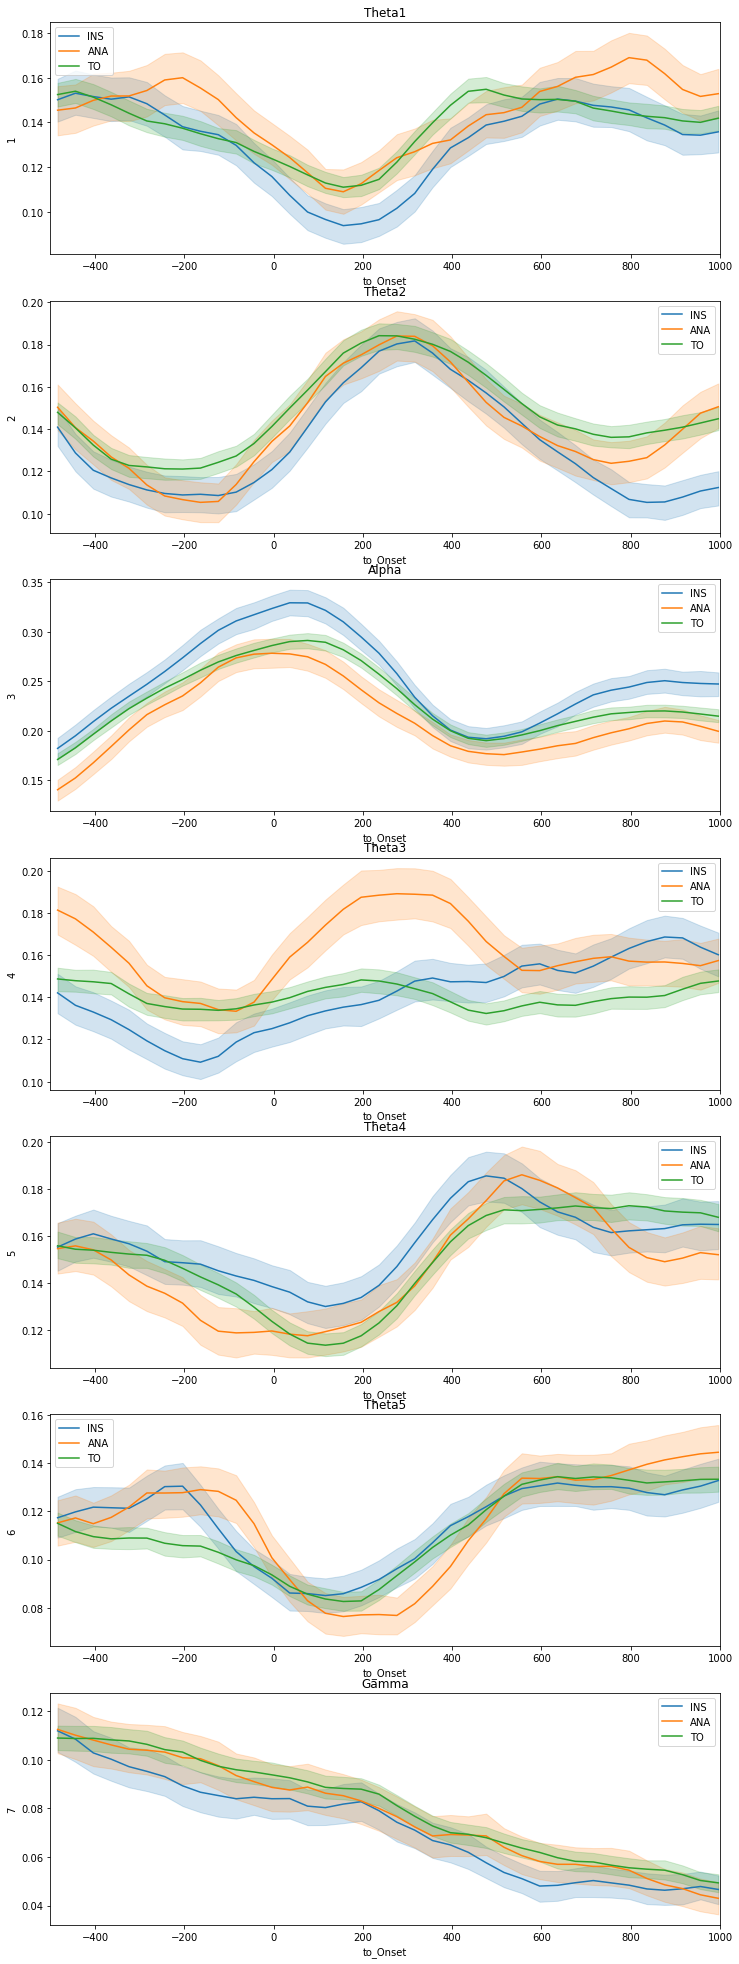

In [13]:
fig,ax=plt.subplots(n,1,figsize=(12,35))

for i in range(n):
    for style in ['INS','ANA','TO']:
        sns.lineplot(data=allstateDF[style][(allstateDF[style]['to_Onset']<1000)&(allstateDF[style]['to_Onset']>-500)], 
                     x="to_Onset", y=i+1,ci=68,ax=ax[i])
    ax[i].set_xlim(-500,1000)
    ax[i].legend(labels=['INS','ANA','TO'])
    ax[i].set_title(statelabels[i])

plt.show()
plt.close()

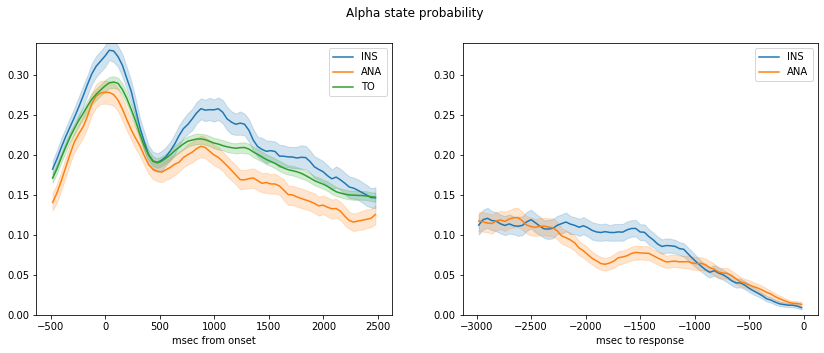

In [14]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
cnt=0
i=2 #index for the alpha state
for style in ['INS','ANA','TO']:
    sns.lineplot(data=allstateDF[style][(allstateDF[style]['to_Onset']>-500)&(allstateDF[style]['to_Onset']<2500)&
                                            (allstateDF[style]['to_Last']<-2000)], 
                     x="to_Onset", y=i+1,ci=68,ax=ax[0])
ax[0].legend(labels=['INS','ANA','TO'])
ax[0].set_ylim(0.00,0.34)
#ax[0].set_title(statelabels[i]+' state probability')
ax[0].set_xlabel('msec from onset')
ax[0].set_ylabel('')
for style in ['INS','ANA']:
    sns.lineplot(data=allstateDF[style][(allstateDF[style]['to_Onset']>2000)&(allstateDF[style]['to_Last']>-3000)&
                                            (allstateDF[style]['to_Last']<0)], 
                     x="to_Last", y=i+1,ci=68,ax=ax[1])
ax[1].legend(labels=['INS','ANA'])
#ax[1].set_title(statelabels[i]+' state probability')
ax[1].set_xlabel('msec to response')
ax[1].set_ylabel('')
ax[1].set_ylim(0.0,0.34)
plt.suptitle(statelabels[i]+' state probability')
plt.show()
plt.close()

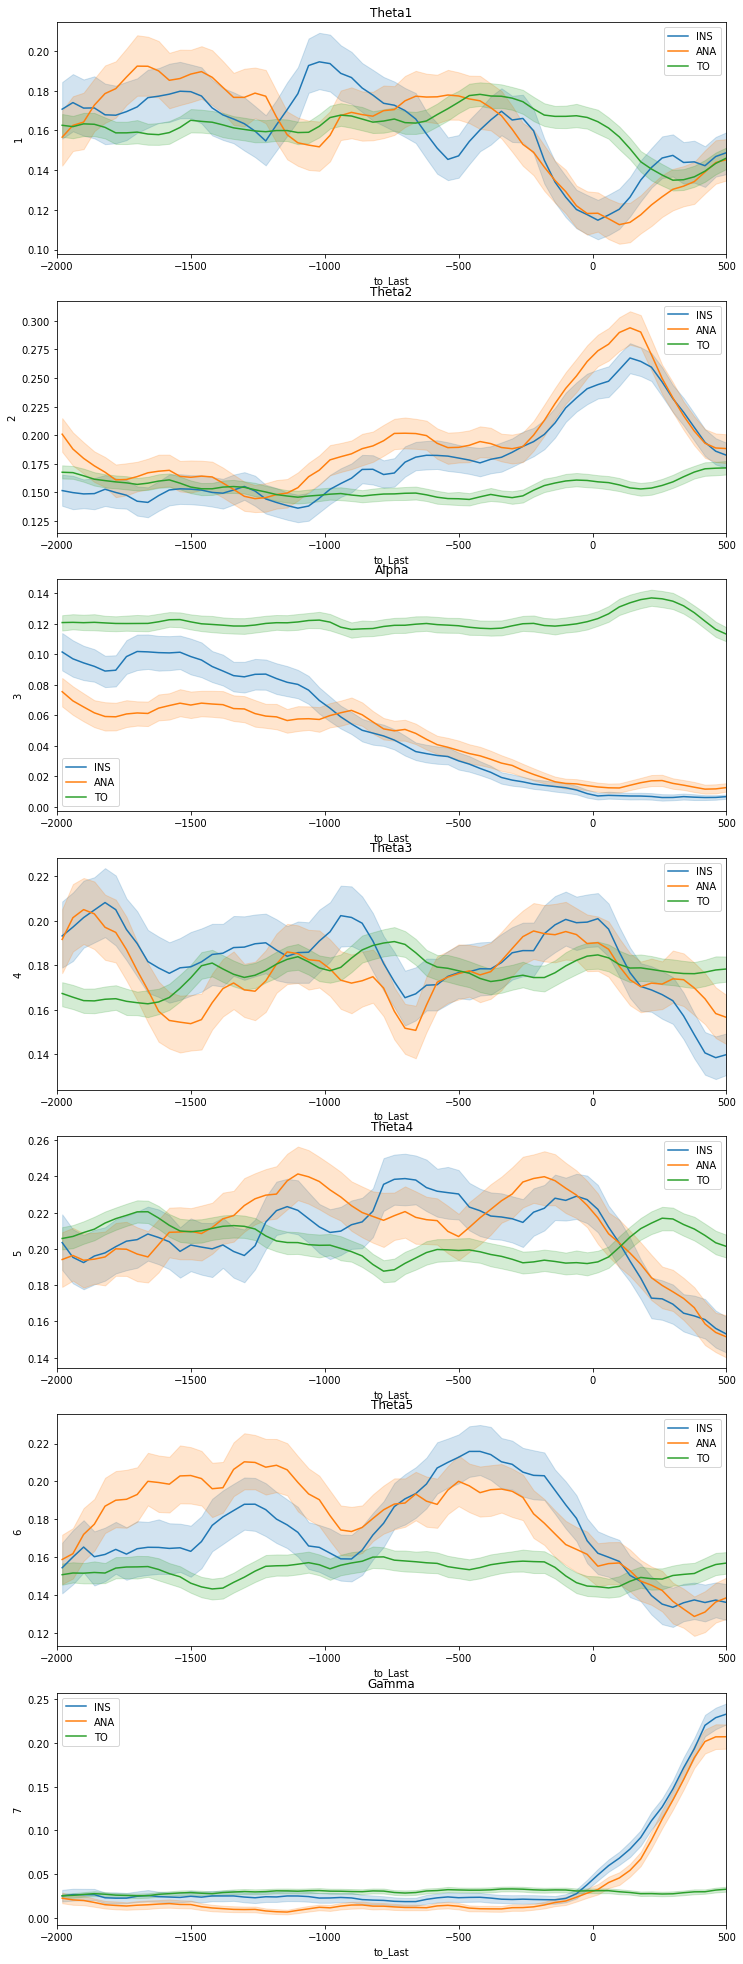

In [16]:
fig,ax=plt.subplots(n,1,figsize=(12,35))

for i in range(n):
    for style in ['INS','ANA','TO']:
        sns.lineplot(data=allstateDF[style][(allstateDF[style]['to_Onset']>3000)&(allstateDF[style]['to_Last']>-2000)], 
                     x="to_Last", y=i+1,ci=68,ax=ax[i])
    ax[i].set_xlim(-2000,500)
    ax[i].legend(labels=['INS','ANA','TO'])
    ax[i].set_title(statelabels[i])

plt.show()
plt.close()

# Four stage analysis

In [17]:
stepsize=40#ms
allstate['statelst']=allstate['state'].shift(1)
allstate['tchg']=allstate['to_Onset'].diff()
allstate.loc[~(allstate['tchg']==40),'statelst']=np.nan
allstate['chg']=~(allstate['state']==allstate['statelst'])
allstate['chgflag']=(~(allstate['chg']==0)).astype(int)
allstate['chgflag']=allstate['chgflag'].cumsum()

In [18]:
cutoff=1000
result=pd.DataFrame()
zscore=pd.DataFrame()
result_se=pd.DataFrame()
tmp,tmp_se,ztmp=computeStats(allstate[(allstate['to_Onset']<0)])
tmp['stage']=-1
ztmp['stage']=-1
tmp_se['stage']=-1
result=pd.concat([result,tmp])
result_se=pd.concat([result_se,tmp_se])
zscore=pd.concat([zscore,ztmp])
tmp,tmp_se,ztmp=computeStats(allstate[(allstate['to_Onset']>0)&(allstate['to_Last']<-1*cutoff)&(allstate['to_Onset']<cutoff)])
tmp['stage']=0
ztmp['stage']=0
tmp_se['stage']=0
result_se=pd.concat([result_se,tmp_se])
result=pd.concat([result,tmp])
zscore=pd.concat([zscore,ztmp])
tmp,tmp_se,ztmp=computeStats(allstate[(allstate['to_Onset']>cutoff)&(allstate['to_Last']<-1*cutoff)&(allstate['to_Onset']<9000)])
tmp['stage']=1
ztmp['stage']=1
tmp_se['stage']=1
result_se=pd.concat([result_se,tmp_se])
result=pd.concat([result,tmp])
zscore=pd.concat([zscore,ztmp])
tmp,tmp_se,ztmp=computeStats(allstate[(allstate['to_Onset']>cutoff)&(allstate['to_Last']>-1*cutoff)&(allstate['to_Last']<0)])
tmp['stage']=2
ztmp['stage']=2
tmp_se['stage']=2
result_se=pd.concat([result_se,tmp_se])
result=pd.concat([result,tmp])
zscore=pd.concat([zscore,ztmp])

In [19]:
import ipywidgets as widgets
from IPython.display import display, HTML
for i in range(n):
    print(statelabels[i])
    
    display(HTML(np.round(zscore.loc[i,:],3).to_html(index=False)))
 

Theta1


proportion,visitlen,visitfreq,stage
-1.242,0.176,-1.372,-1
-1.841,-0.412,-1.652,0
-0.376,-0.808,0.066,1
0.047,-1.558,1.063,2


Theta2


proportion,visitlen,visitfreq,stage
-0.748,-0.142,-0.655,-1
-1.158,0.888,-1.726,0
-2.392,-0.998,-2.441,1
-1.630,-1.271,-0.728,2


Alpha


proportion,visitlen,visitfreq,stage
2.354,2.056,1.011,-1
2.552,1.298,1.621,0
2.933,0.601,3.840,1
0.434,0.492,0.201,2


Theta3


proportion,visitlen,visitfreq,stage
-2.111,-0.338,-1.967,-1
-1.493,-0.559,-1.149,0
1.257,1.747,0.374,1
-0.347,-0.776,0.173,2


Theta4


proportion,visitlen,visitfreq,stage
0.918,-0.484,1.210,-1
1.327,0.684,0.891,0
-1.237,-2.464,0.087,1
0.072,-0.168,0.177,2


Theta5


proportion,visitlen,visitfreq,stage
0.227,0.464,-0.036,-1
0.036,0.697,-0.424,0
-1.306,-1.002,-1.021,1
1.361,0.764,0.815,2


Gamma


proportion,visitlen,visitfreq,stage
-0.124,0.797,-0.649,-1
-0.560,-1.827,0.619,0
0.554,0.992,-0.104,1
0.649,-0.443,1.372,2


1 Theta1


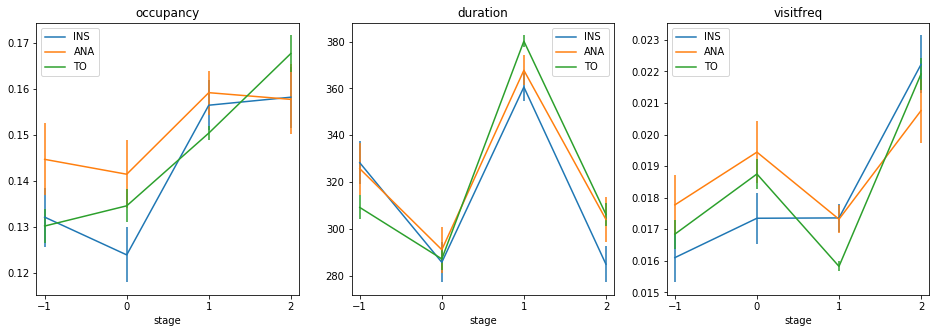

2 Theta2


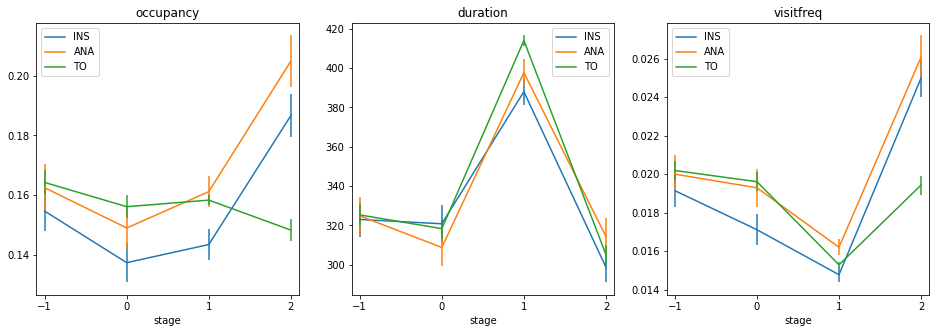

3 Alpha


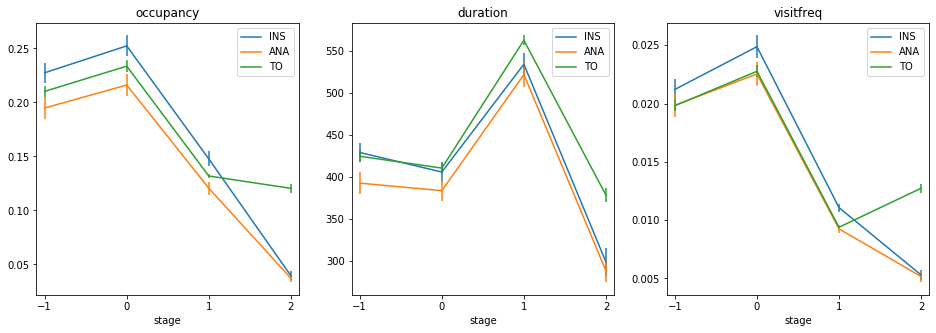

4 Theta3


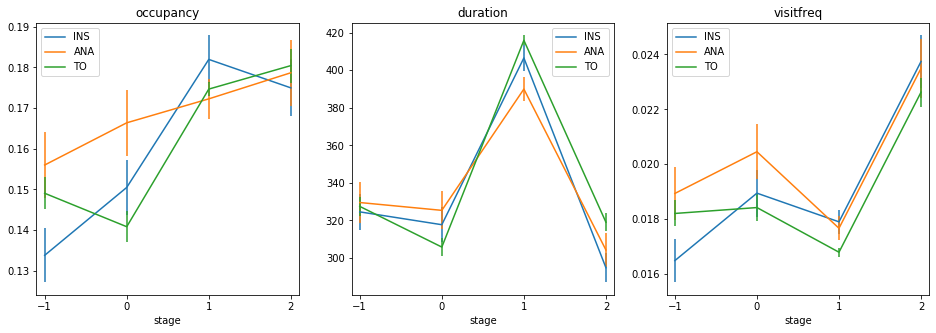

5 Theta4


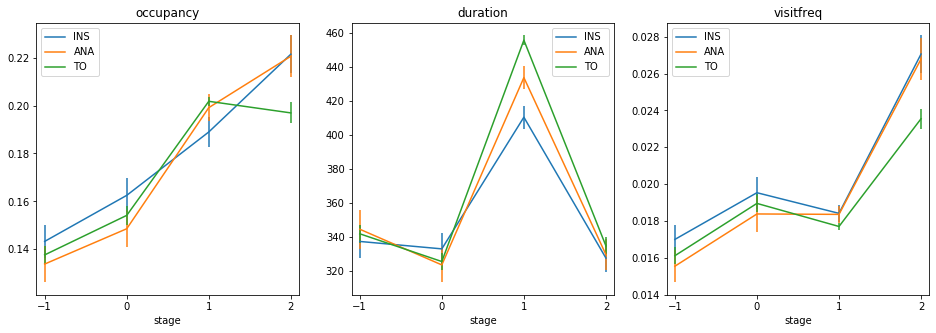

6 Theta5


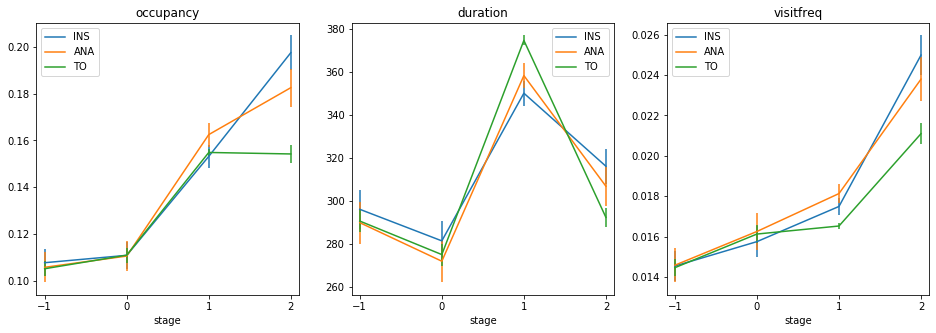

7 Gamma


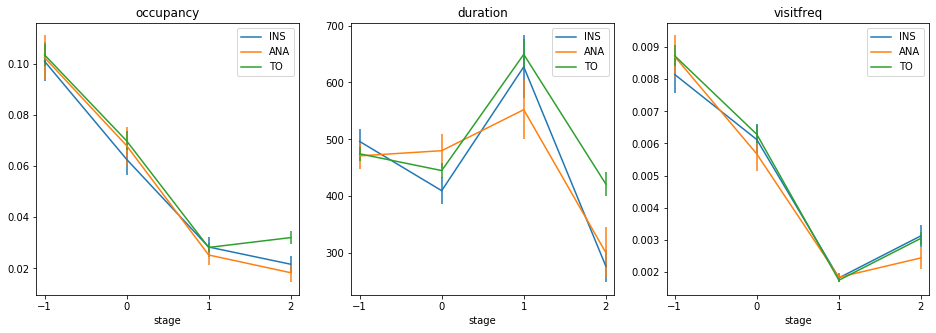

In [21]:

titlerelabel={'proportion':'occupancy','visitlen':'duration','visitfreq':'visitfreq'}
for currentstate in range(n):
    fig1, ax = plt.subplots(1,3,figsize=(16,5))
    axindex=0
    print(currentstate+1,statelabels[currentstate])
    for col in ['proportion','visitlen','visitfreq']:
        tmp=pd.DataFrame([result.loc[currentstate].loc[style].set_index('stage')[col] for style in ['INS','ANA','TO']],index=['INS','ANA','TO']).T
        tmp_se=pd.DataFrame([result_se.loc[currentstate].loc[style].set_index('stage')[col] for style in ['INS','ANA','TO']],index=['INS','ANA','TO']).T
        tmp.plot(xticks=tmp.index,ax=ax[axindex],yerr=tmp_se,xlim=(-1.1,2.1),title=titlerelabel[col])
        axindex+=1
    plt.show()



3 Alpha


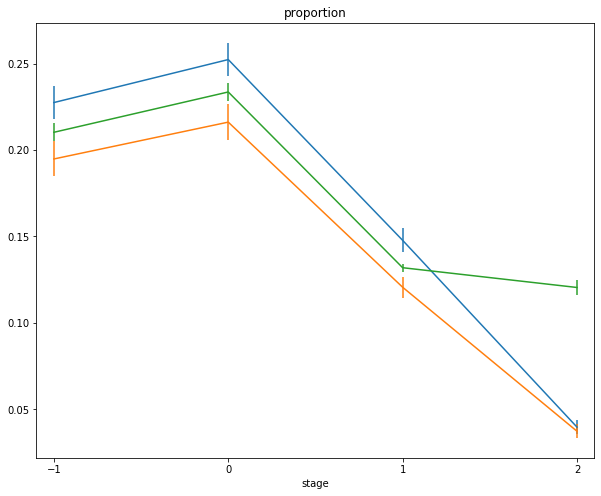

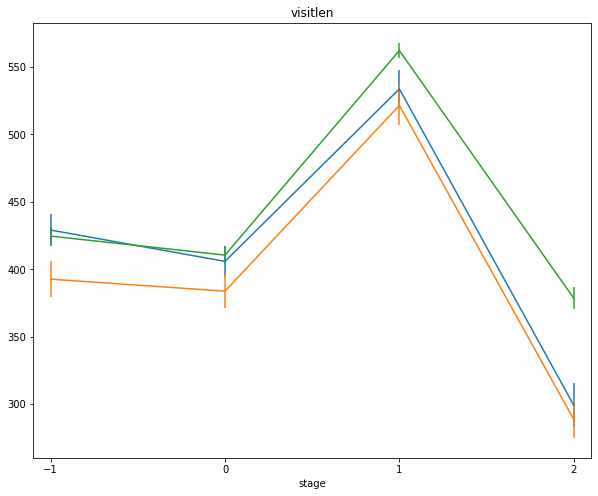

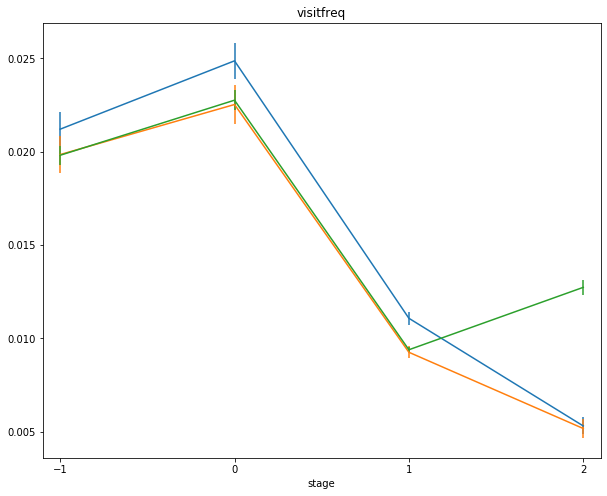

In [22]:
for currentstate in [2]:
    print(currentstate+1,statelabels[currentstate])
    for col in ['proportion','visitlen','visitfreq']:
        fig1, ax = plt.subplots(1,figsize=(10,8))
        tmp=pd.DataFrame([result.loc[currentstate].loc[style].set_index('stage')[col] for style in ['INS','ANA','TO']],index=['INS','ANA','TO']).T
        tmp_se=pd.DataFrame([result_se.loc[currentstate].loc[style].set_index('stage')[col] for style in ['INS','ANA','TO']],index=['INS','ANA','TO']).T
        tmp.plot(xticks=tmp.index,title=col,ax=ax,yerr=tmp_se,xlim=(-1.1,2.1),legend=False)
        plt.show()
        plt.close

# Durations

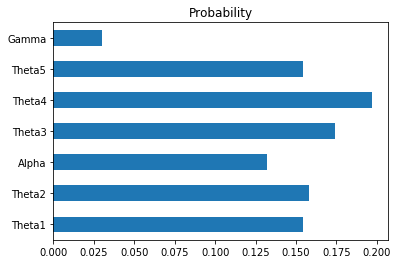

In [23]:
tmp=allstate[(allstate['to_Last']<0)&(allstate['to_Onset']>0)]
tmp=pd.DataFrame({'prob':tmp[states].mean().values,'label':statelabels}).set_index('label')
ax=tmp.loc[statelabels].plot(kind='barh',legend=False)
ax.set_ylabel('')
ax.set_title('Probability')
plt.show()
plt.close()

In [24]:
tmp=allstate[(allstate['to_Last']<0)&(allstate['to_Onset']>0)]
visitlen=pd.DataFrame()
statecnt=tmp.groupby(['state','chgflag']).count()[1]
statecnt=stepsize*statecnt.unstack(level=1)
tmp=pd.DataFrame(dict([(statelabels[i],pd.Series(statecnt.loc[i].dropna().values)) for i in range(7)]))
tmp.head()

,Theta1,Theta2,Alpha,Theta3,Theta4,Theta5,Gamma
0,160.000,200.000,320.000,440.000,120.000,480.000,200.000
1,80.000,760.000,320.000,400.000,320.000,440.000,360.000
2,240.000,320.000,320.000,440.000,240.000,480.000,80.000
3,240.000,480.000,320.000,240.000,1000.000,200.000,520.000
4,240.000,360.000,520.000,200.000,840.000,320.000,400.000


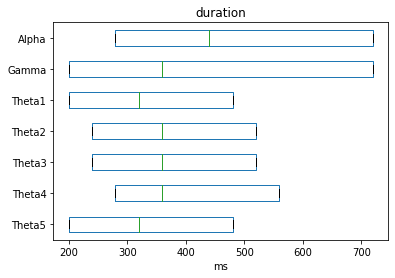

In [26]:
ax=tmp[['Theta5','Theta4','Theta3','Theta2','Theta1','Gamma','Alpha']].plot(kind='box',showfliers=False,vert=False,whis=0,title='duration')
ax.set_xlabel('ms')
plt.show()
plt.close()

In [29]:
allvisitlen=pd.DataFrame()
allvisitlen_sd=pd.DataFrame()
for style in ['INS','ANA','TO']:
#for style in ['INS']:
    tmp=allstate[(allstate['to_Last']<0)&(allstate['to_Onset']>0)&(allstate['style']==style)]
    exclude=[]
    if style=='TO':
        tmp=tmp[tmp['to_Onset']<125*stepsize]
    else:
        exclude=[]
    statecnt=tmp[~tmp['id'].isin(exclude)].groupby(['state','chgflag']).count()[1]
    statecnt=stepsize*statecnt.unstack(level=1)
    visitlen=pd.DataFrame(dict([(statelabels[i],pd.Series(statecnt.loc[i].dropna().values)) for i in range(7)]))
    allvisitlen.loc[:,style]=visitlen.mean()
    allvisitlen_sd.loc[:,style]=visitlen.describe().loc['std']/np.sqrt(visitlen.describe().loc['count'])


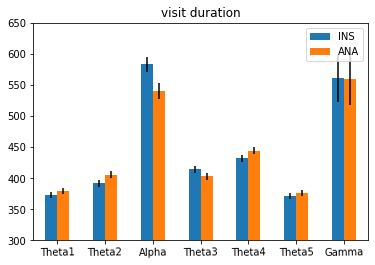

In [30]:
allvisitlen[['INS','ANA']].plot(kind='bar',rot=True,yerr=allvisitlen_sd[['INS','ANA']].T.values,ylim=(300,650),title='visit duration')
plt.show()
plt.close()

# Onset and response locked, aligned by number of transitions

In [31]:
solvedall=allstate[allstate['style'].isin(['ANA','INS'])]
solvedall=solvedall[(solvedall['to_Last']<=0)]
stepsize=40#ms
onsetms=-4
solvedall['statelst']=solvedall['state'].shift(1)
solvedall['change']=~(solvedall['state']==solvedall['statelst'])
solvedall.set_index(['style','id'],inplace=True)

In [33]:
datadf=pd.DataFrame()
for i,r in solvedall.groupby(['style','id']):
    r.ix[0,'change']=True
    tmp=r[r['change']][['to_Onset','to_Last','state']+states]
    tmp['dur']=tmp['to_Onset'].diff().shift(-1)
    tmp.sort_values('to_Onset',ascending=False,inplace=True)
    tmp['state2Last']=range(len(tmp))
    try:
        onset_index=tmp[tmp['to_Onset']<0]['state2Last'].values[0]
    except:
        #no transition after onset
        onset_index=-1
    tmp['state2Last']=-1*tmp['state2Last']
    tmp['sinceOnset']=tmp['state2Last']+onset_index
    datadf=pd.concat([datadf,tmp])
datadf.head()

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


to_Onset  to_Last  state     1     2     3     4     5     6  \
style id                                                                       
ANA   (102, 1)      8796     -460      5 0.009 0.185 0.008 0.284 0.024 0.481   
      (102, 1)      6916    -2340      1 0.049 0.539 0.001 0.408 0.002 0.002   
      (102, 1)      6676    -2580      3 0.003 0.001 0.003 0.803 0.186 0.005   
      (102, 1)      6116    -3140      4 0.007 0.001 0.084 0.000 0.908 0.000   
      (102, 1)      5916    -3340      2 0.003 0.020 0.665 0.279 0.002 0.031   

                   7      dur  state2Last  sinceOnset  
style id                                               
ANA   (102, 1) 0.009      nan           0          17  
      (102, 1) 0.000 1880.000          -1          16  
      (102, 1) 0.000  240.000          -2          15  
      (102, 1) 0.000  560.000          -3          14  
      (102, 1) 0.000  200.000          -4          13

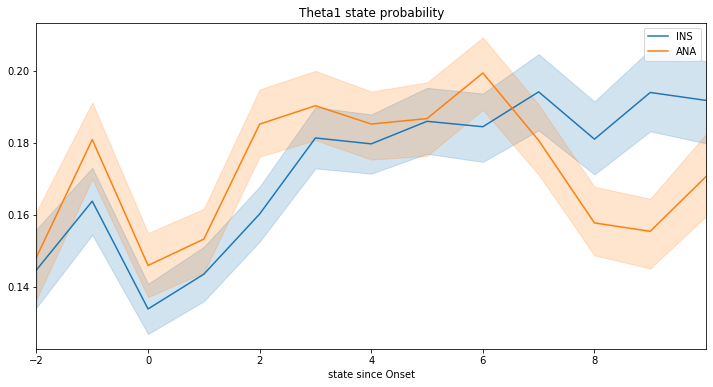

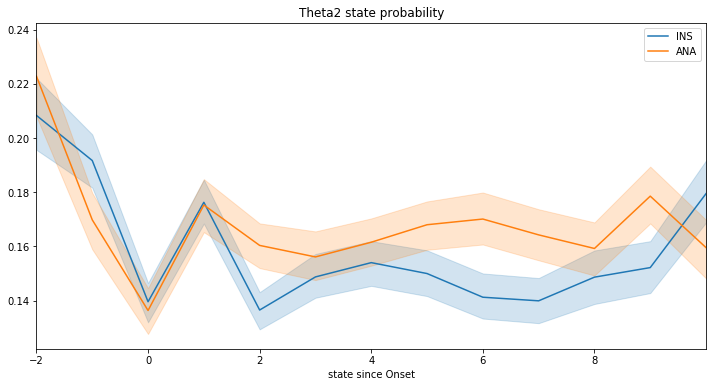

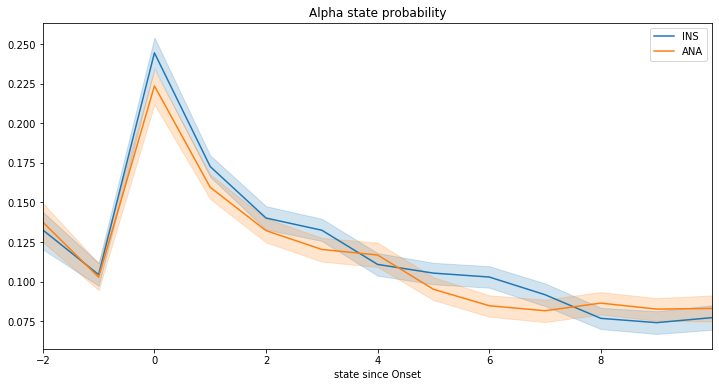

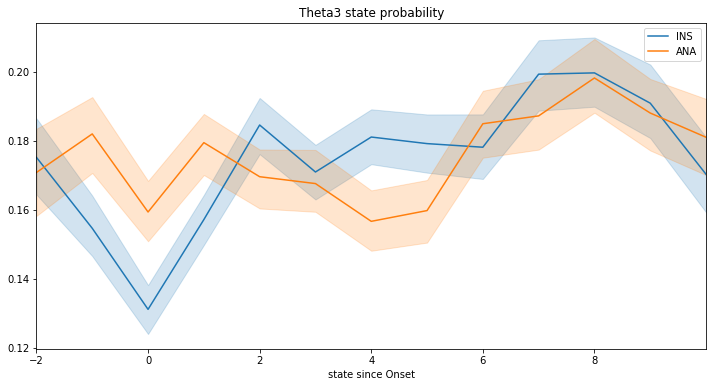

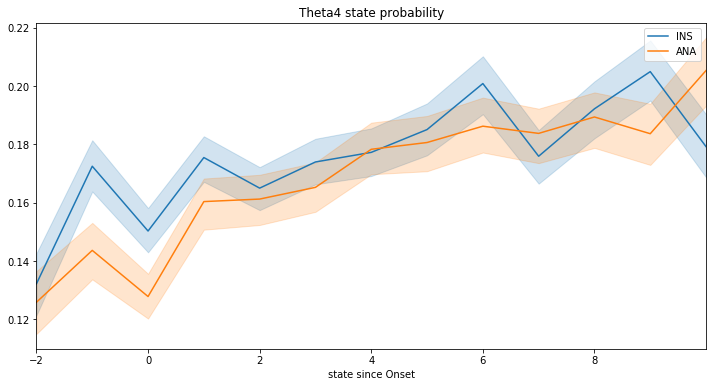

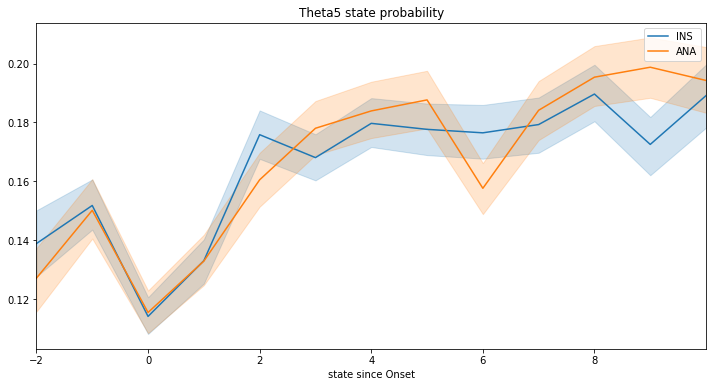

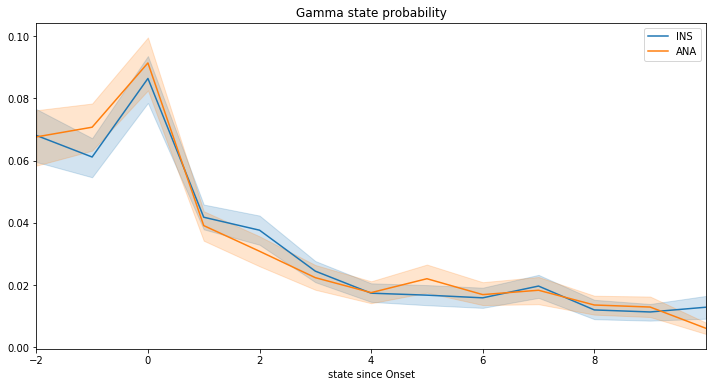

In [114]:
for i in range(n):
    fig,ax=plt.subplots(1,figsize=(12,6))
    for style in ['INS','ANA']:
        sns.lineplot(data=datadf[(datadf['sinceOnset']<=10)&(datadf['state2Last']<0)&(datadf['sinceOnset']>-3)].loc[style],x="sinceOnset", y=i+1,ci=68,ax=ax)
    ax.legend(labels=['INS','ANA'])
    ax.set_title(statelabels[i]+ ' state probability')
    ax.set_xticks(range(-2,10,2))
    ax.set_xlabel('state since Onset')
    ax.set_ylabel('')
    ax.set_xlim(-2,10)
    plt.show()
    plt.close()

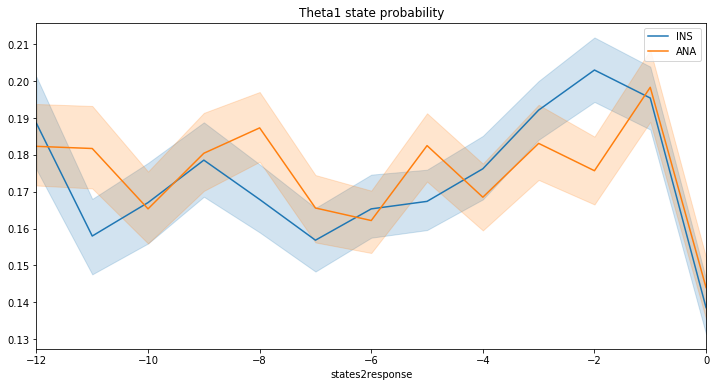

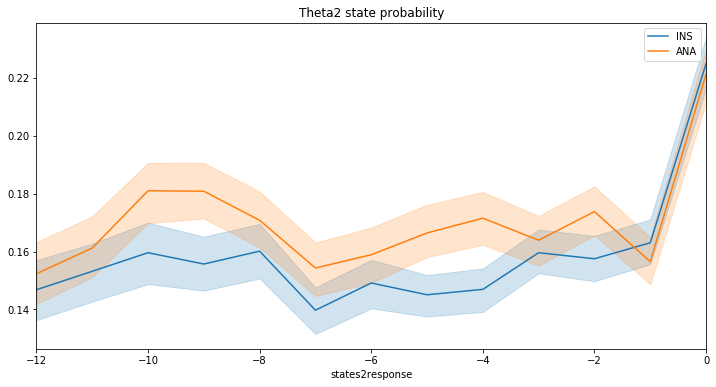

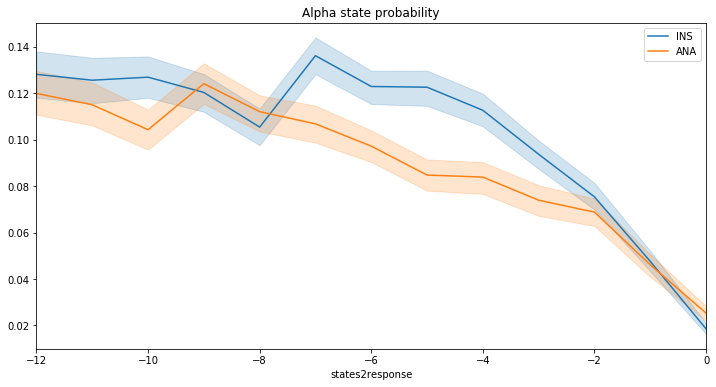

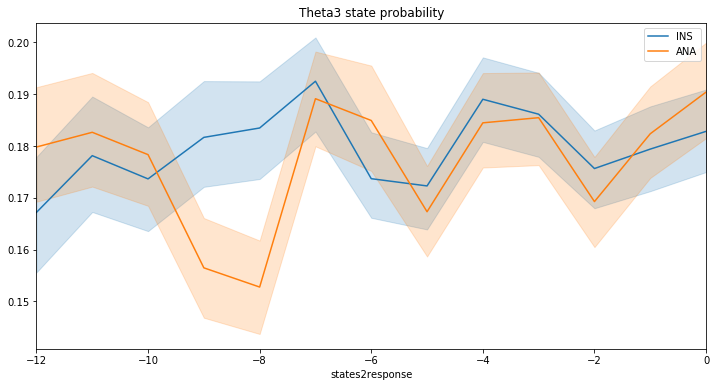

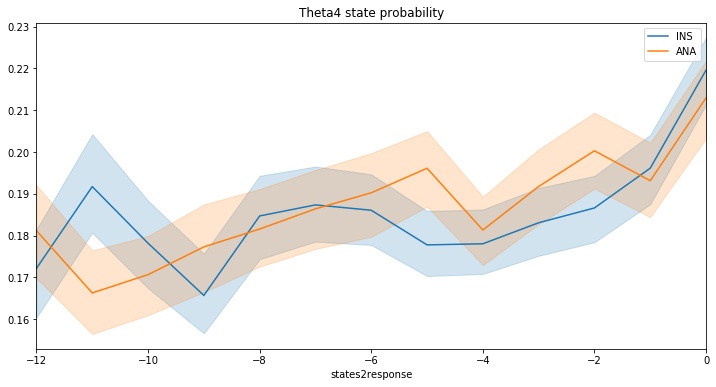

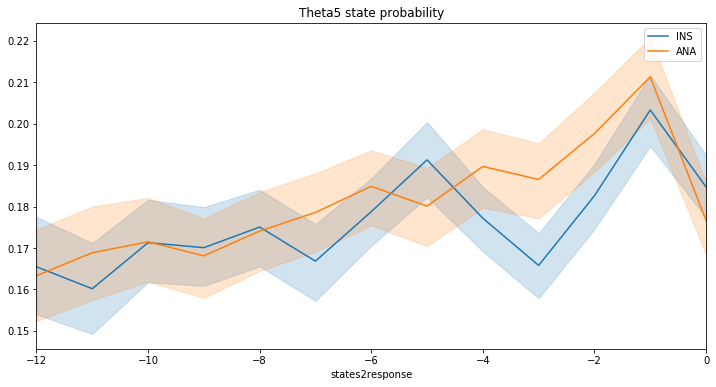

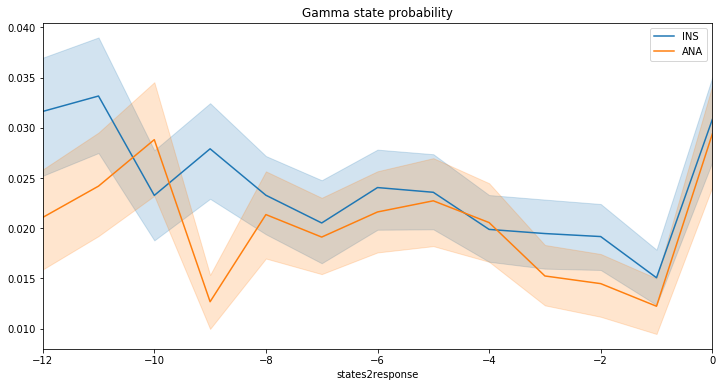

In [116]:
for i in range(n):
    fig,ax=plt.subplots(1,figsize=(12,6))
    for style in ['INS','ANA']:
        sns.lineplot(data=datadf[(datadf['sinceOnset']>=0)&(datadf['state2Last']>=-12)].loc[style],x="state2Last", y=i+1,ci=68,ax=ax)
    ax.legend(labels=['INS','ANA'])
    ax.set_title(statelabels[i]+ ' state probability')
    ax.set_xticks(range(-12,2,2))
    ax.set_xlabel('states2response')
    ax.set_ylabel('')
    ax.set_xlim(-12,0)
    plt.show()
    plt.close()

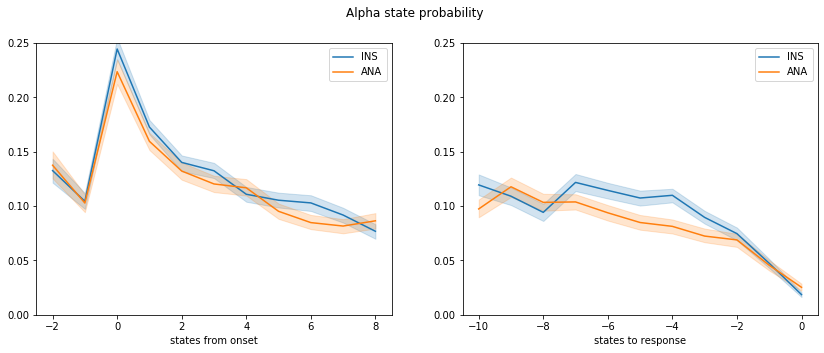

In [36]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
cnt=0
i=2
for style in ['INS','ANA']:
    sns.lineplot(data=datadf[(datadf['sinceOnset']<=8)&(datadf['state2Last']<0)&(datadf['sinceOnset']>-3)].loc[style],
                 x="sinceOnset", y=i+1,ci=68,ax=ax[0])
ax[0].legend(labels=['INS','ANA'])
ax[0].set_ylim(0.0,0.25)
#ax[0].set_title(statelabels[i]+' state probability')
ax[0].set_xlabel('states from onset')
ax[0].set_ylabel('')
for style in ['INS','ANA']:
    sns.lineplot(data=datadf[(datadf['sinceOnset']>0)&(datadf['state2Last']>=-10)].loc[style],
                 x="state2Last", y=i+1,ci=68,ax=ax[1])
ax[1].legend(labels=['INS','ANA'])
#ax[1].set_title(statelabels[i]+' state probability')
ax[1].set_xlabel('states to response')
ax[1].set_ylabel('')
ax[1].set_ylim(0.0,0.25)
plt.suptitle(statelabels[i]+' state probability')
plt.show()
plt.close()

# Change before response

In [40]:
allzscore=[]
diff_DF={}
for cutoff in np.arange(-2000,0,200):
    for cutoff0 in np.arange(-1800,100,200):
        if cutoff>=cutoff0: continue
        for style in ['ANA','INS']:
            diff=[]
            for i,g in allstateDF[style].groupby('id'):
              
                probs=(g[g['to_Last']<=cutoff0].iloc[-1].loc[states])-(g[g['to_Last']>=cutoff].iloc[0].loc[states])
                diff.append(probs.values)
          
            diff_DF[style]=pd.DataFrame(diff,columns=states)[states[statelabels.index('Alpha')]]
        allzscore.append([cutoff,cutoff0,(diff_DF['INS'].mean()-diff_DF['ANA'].mean())/np.sqrt(diff_DF['INS'].var()/len(diff_DF['INS'])
                                            +diff_DF['ANA'].var()/len(diff_DF['ANA']))])
   


            

In [41]:
zDF=pd.DataFrame(allzscore,columns=['t1','t2','z']).pivot(index='t1',columns='t2',values='z').T.fillna(0).sort_index(ascending=True)
zDF

t1,-2000,-1800,-1600,-1400,-1200,-1000,-800,-600,-400,-200
t2,,,,,,,,,,
-1800,-1.204,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
-1600,-1.579,-0.693,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
-1400,-1.596,-0.678,-0.350,0.000,0.000,0.000,0.000,0.000,0.000,0.000
-1200,-1.869,-0.946,-0.582,-0.430,0.000,0.000,0.000,0.000,0.000,0.000
-1000,-2.594,-1.684,-1.280,-1.191,-1.460,0.000,0.000,0.000,0.000,0.000
-800,-3.935,-3.026,-2.580,-2.540,-2.706,-1.581,0.000,0.000,0.000,0.000
-600,-4.079,-3.171,-2.716,-2.626,-2.560,-1.111,-0.337,0.000,0.000,0.000
-400,-4.596,-3.687,-3.172,-3.094,-2.963,-1.473,-0.739,-1.066,0.000,0.000
-200,-5.176,-4.257,-3.640,-3.545,-3.421,-1.847,-1.076,-1.189,-0.395,0.000


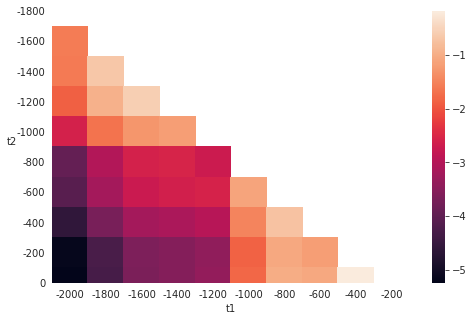

In [42]:
mask = np.zeros_like(zDF)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 5))
    #ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)
    ax = sns.heatmap(zDF, mask=mask)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_ylabel(ax.get_ylabel(), rotation=0)
    
